# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).


print('azdias dataset shape is :', azdias.shape)
print('feat_info dataset shape is:', feat_info.shape)

azdias dataset shape is : (891221, 85)
feat_info dataset shape is: (85, 4)


In [7]:


azdias.head(5)



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info['missing_or_unknown'].value_counts()


[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[XX]         1
[-1,XX]      1
[-1,X]       1
Name: missing_or_unknown, dtype: int64

In [10]:


# Identify missing or unknown data values and convert them to NaNs.
column = feat_info['attribute'].tolist()
missing_values = feat_info['missing_or_unknown'].apply(lambda x:x[1:-1].split(','))



In [11]:


for i in range(azdias.shape[1]):
    for j in range (len(missing_values[i])):
        value = missing_values[i][j]
        azdias[column[i]].replace((int(value) if value.isdigit() else(str(value) if value.isalpha() else(str(value) if value == '' else float(value)))),np.nan, regex=True, inplace=True)



In [12]:
#checking
azdias.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_before= print('Number of missing values before processing is :', azdias.isnull().sum().sum())



Number of missing values before processing is : 8373929


In [14]:
# Investigate patterns in the amount of missing data in each column.

azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


#looping for each column in azdias
for column in range(azdias.shape[1]):
    # pick one column of azdias
    col_featue=azdias.columns[column]
    #clean missing_or_unknown 
    missing_list=feat_info.iloc[column,3]
    missing_list=missing_list.replace('[', '').replace(']', '').split(',')
    if missing_list == ['']:
        continue
    else:
        for unknown_code in missing_list:
            if azdias[col_featue].dtype =='object':
                azdias.loc[azdias[col_featue]==unknown_code,col_featue]=np.nan 
            else:   
                unknown_code=int(unknown_code)
                azdias.loc[azdias[col_featue]==unknown_code,col_featue]=np.nan



In [16]:
null_values =(azdias.isnull().sum()/ azdias.shape[0]).sort_values(ascending=False)*100
null_values

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [17]:

missing_after= print('Number of missing values after processing is :', azdias.isnull().sum().sum())



Number of missing values after processing is : 8373929


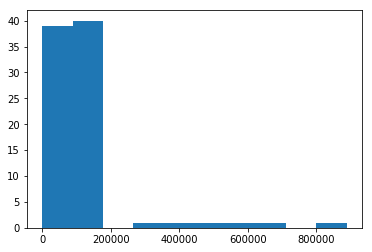

In [18]:
# Investigate patterns in the amount of missing data in each column.
countcol=pd.DataFrame(azdias.shape[0] - azdias.count())
countcol.columns=['count']
plt.hist(countcol['count']);

In [19]:
old_data=azdias.shape
print(' azdias data before removing outliar:',old_data)

 azdias data before removing outliar: (891221, 85)


In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlairs=countcol[countcol['count']>200000]
azdias=azdias.drop(outlairs.index, axis=1)

In [21]:
outlairs

,count
AGER_TYP,685843
GEBURTSJAHR,392318
TITEL_KZ,889061
ALTER_HH,310267
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524


In [22]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column


after analyzing the data, we found  that we have 6 column of outliers with large amount of missing data (>200,000 missing data) so I decided to  remove it.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?
missing_values_in_rows = azdias.isnull()
total_missing = missing_values_in_rows.sum(axis=1)

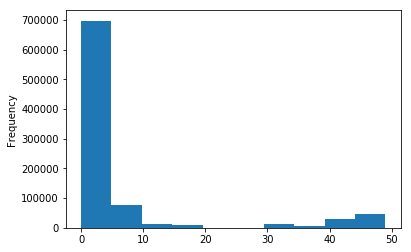

In [24]:

total_missing.plot.hist(grid=False)


In [25]:
num_null_rows= azdias.isnull().sum(axis=1)

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_above30 = azdias[num_null_rows >= 30]
missing_below30 = azdias[num_null_rows < 30]
missing_above30.shape

(93160, 79)

In [27]:
#Columns with zero missing data
zero_missing_columns=[]
for i in range(null_values.shape[0]):
    if(null_values[i]==0):
        zero_missing_columns.append(null_values.index[i])
zero_missing_columns

['FINANZTYP',
 'GREEN_AVANTGARDE',
 'FINANZ_HAUSBAUER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'FINANZ_MINIMALIST',
 'ANREDE_KZ',
 'FINANZ_VORSORGER',
 'SEMIO_FAM',
 'SEMIO_SOZ',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
   
def compare_plot(column_name):
    fig = plt.figure(10, figsize=(12,4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('High missing Rows')
    sns.countplot(missing_above30[column_name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Less Missing Rows')
    sns.countplot(missing_below30[column_name])
                                                       
    fig.suptitle(column)
    plt.show()


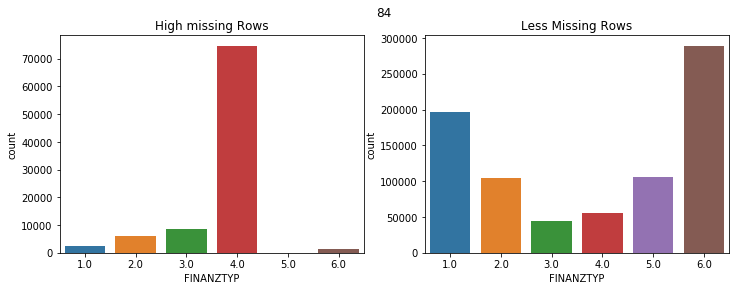

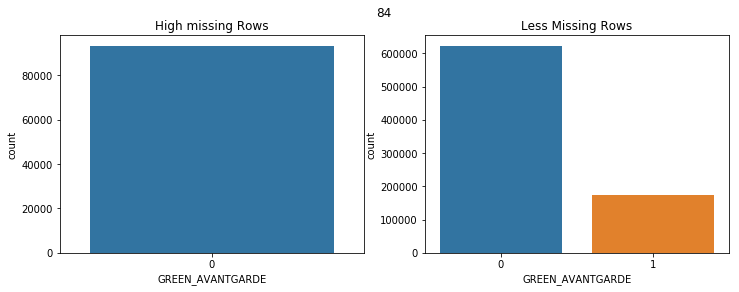

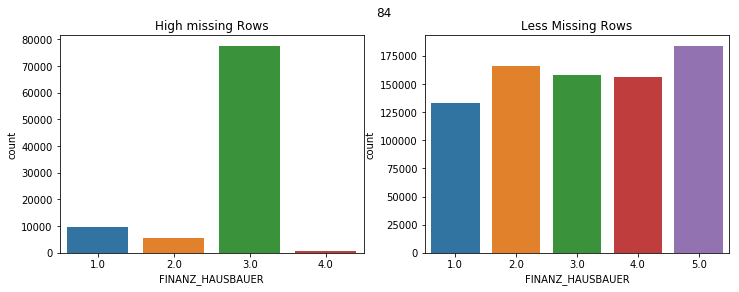

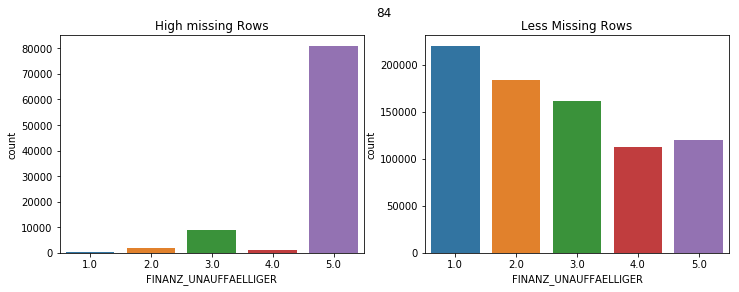

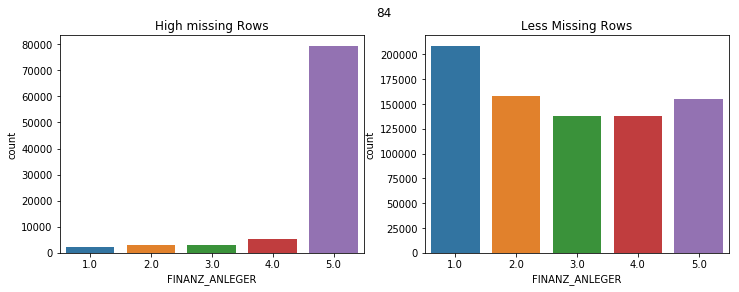

In [29]:
for i in range(5):
    compare_plot(zero_missing_columns[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row
in this part i have done the following:
1- devided data into two groups(with high missing amount| with less missing) 
and compare the data distripution,we notice that The data have different distribution 
2- Replace the nan with Mode (most frequent value in each category)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info.head()


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [31]:

feat_info=feat_info[feat_info.attribute.isin(missing_below30.columns)]

In [32]:


feat_info.type.value_counts()



ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:


categorical_valus = feat_info[feat_info.type=='categorical']
categorical_valus

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

multi_level = []
binary = []
for column in categorical_valus.attribute.values:
    if missing_below30[column].nunique() > 2:
        multi_level.append(column)
    else:
        binary.append(column)

In [35]:
for col in binary:
    print(missing_below30[col].value_counts())

#Except OST_WEST_KZ all are numnerial, Hence encoding OST_WEST_KZ along with multi level data\
multi_level.append('OST_WEST_KZ')

2.0    416177
1.0    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.


missing_below30 = pd.get_dummies(missing_below30, columns=multi_level)

In [37]:
missing_below30.shape

(798061, 195)

In [38]:
missing_below30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Columns: 195 entries, ALTERSKATEGORIE_GROB to OST_WEST_KZ_W
dtypes: float64(63), int64(1), object(1), uint8(130)
memory usage: 520.8+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features


We have re encoded binary categorical values by using get_dummies  to convert it to 0s and 1s.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:

mixed_type = feat_info[feat_info.type=='mixed']
mixed_type


,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [40]:
#create dictionary 

decade_Dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_Dictionary={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
wealth_Dictionary={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life_Dictionary={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }


In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
missing_below30["DECADE"]=missing_below30.PRAEGENDE_JUGENDJAHRE
missing_below30["MOVEMENT"]=missing_below30.PRAEGENDE_JUGENDJAHRE

In [42]:


missing_below30["DECADE"].replace(decade_Dictionary,inplace=True)

missing_below30["MOVEMENT"].replace(movement_Dictionary,inplace=True)

missing_below30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)




In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.



#create two features
missing_below30["WEALTH"]=missing_below30.CAMEO_INTL_2015
missing_below30["LIFE_STAGE"]=missing_below30.CAMEO_INTL_2015
#replace with new variables
missing_below30["WEALTH"].replace(wealth_Dictionary,inplace=True)
missing_below30["LIFE_STAGE"].replace(life_Dictionary,inplace=True)
#drop the CAMEO_INTL_2015 column
missing_below30.drop("CAMEO_INTL_2015",axis=1,inplace=True)

In [44]:
missing_below30.shape

(798061, 197)

#### Discussion 1.2.2: Engineer Mixed-Type Features

for the mixed featuers CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE i did  the following:


1.create dictionary for each variable
2- map  the value from data dictionary to get features.
3- drop the original featuers




#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

missing_below30.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', '

In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

missing_below30.shape

(798061, 197)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:


def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    missing_values = feat_info['missing_or_unknown'].apply(lambda x:x[1:-1].split(','))
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
        if missing_values_list[0] != "": # if the list not empty 
            for missing_value in missing_values_list:
                #check if the missing value is number (negative or positive numbers)
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)

                df.loc[df[attribute] == missing_value, attribute] = np.nan
    
    

    # remove selected columns and rows, ...
    #drop columns 
    columns=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ']
    df.drop(columns=columns,axis="columns",inplace=True)
    #rows
    num_null_rows=df.isnull().sum(axis=1)
    missing_below30=df[num_null_rows<30]
    missing_above30=df[num_null_rows>=30]
    missing_below30 =missing_below30.fillna(missing_below30.mode().iloc[0])
     
    # select, re-encode, and engineer column values.
    feat_info=feat_info[feat_info.attribute.isin(missing_below30.columns)]
    categ_variables=feat_info[feat_info.type=="categorical"]
    
    binary_categories=[]
    multi_level=[]

    for col in categ_variables.attribute:
        if missing_below30[col].nunique()==2:
            binary_categories.append(col)
        else:
            multi_level.append(col)
            
    # Re-encode categorical variable(s) to be kept in the analysis.
    missing_below30["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
    missing_below30["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    missing_below30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
    missing_below30=pd.get_dummies(data=missing_below30,columns=multi_level)
    
    #create dictionaries 
    
    
    
    decade_Dictionary={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_Dictionary={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    wealth_Dictionary={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
    life_Dictionary={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5}

   # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    missing_below30["DECADE"]=missing_below30.PRAEGENDE_JUGENDJAHRE
    missing_below30["MOVEMENT"]=missing_below30.PRAEGENDE_JUGENDJAHRE
    
    #replace with new variables
    missing_below30["DECADE"].replace(decade_Dictionary,inplace=True)
    missing_below30["MOVEMENT"].replace(movement_Dictionary,inplace=True)
    
    
    #Wealth and Life Stage dict
    
    #create two features
    missing_below30["WEALTH"]=missing_below30.CAMEO_INTL_2015
    missing_below30["LIFE_STAGE"]=missing_below30.CAMEO_INTL_2015
    #replace with new variables
    missing_below30["WEALTH"].replace(wealth_Dictionary,inplace=True)
    missing_below30["LIFE_STAGE"].replace(life_Dictionary,inplace=True)
    
    #drop mixed-type features which including PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    mixed_variables=feat_info[feat_info.type=="mixed"]
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in missing_below30.columns:
            missing_below30.drop(mixed_feature,axis=1,inplace=True)
    

    # Return the cleaned dataframe.
    return missing_below30



## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


missing_below30.isnull().sum()

ALTERSKATEGORIE_GROB      2803
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               36721
LP_LEBENSPHASE_FEIN      50233
LP_LEBENSPHASE_GROB      47340
RETOURTYP_BK_S            4745
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 36721
ANZ_PERSONEN                 0
                         ...  
CAMEO_DEU_2015_5C            0
CAMEO_DE

In [49]:

from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imputed_data = pd.DataFrame(imputer.fit_transform(missing_below30), columns = missing_below30.columns, index = missing_below30.index)

In [50]:


imputed_data.isnull().sum().sum()

0

In [51]:
imputed_data.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [52]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_df=pd.DataFrame(scaler.fit_transform(imputed_data), columns = imputed_data.columns, index = imputed_data.index)

In [53]:


scaled_df.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,-0.189539,-0.179782,-0.192768,-0.089764,-0.517426,0.517426,1.098070,0.530409,1.175657,-1.252793
2,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.189539,-0.179782,-0.192768,-0.089764,-0.517426,0.517426,1.098070,-1.885336,-0.869680,0.756034
3,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.189539,-0.179782,-0.192768,-0.089764,-0.517426,0.517426,-0.267778,0.530409,-1.551459,-0.583184
4,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,-0.189539,-0.179782,-0.192768,-0.089764,-0.517426,0.517426,-0.267778,0.530409,0.493878,0.086425
5,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,-0.189539,-0.179782,-0.192768,-0.089764,-0.517426,0.517426,-1.633627,0.530409,1.175657,0.756034


### Discussion 2.1: Apply Feature Scaling
after Imputing the Nan values, I used  the StandardScaler to scaling the features

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [54]:
# Apply PCA to the data.

# Apply PCA to the data.
pca = PCA()
pca.fit(scaled_df)



PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

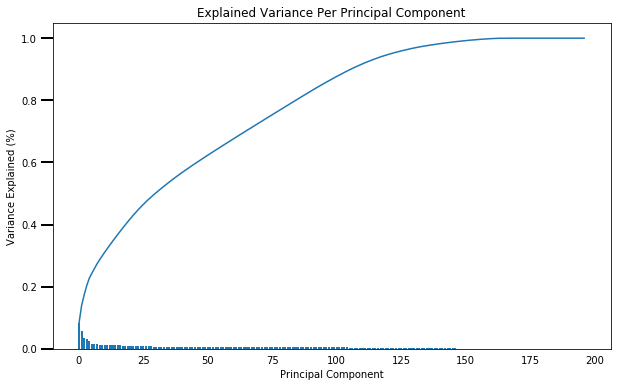

In [55]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    
    Credit:Udacity Nanodegree
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
     #   if(i%5==0):
     #       ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)


In [56]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_80 = PCA(n_components=80)
data_pca = pca_80.fit_transform(scaled_df)


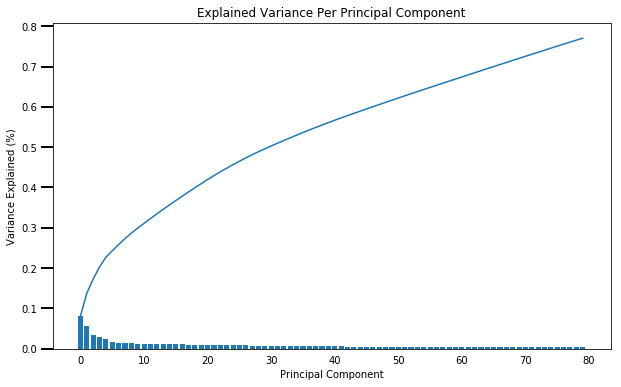

In [57]:


scree_plot(pca_80)



### Discussion 2.2: Perform Dimensionality Reduction

we have almost 200 componenets. so i decide to  go with top 80 components to get  cumulative variance nearly 80% of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

In [59]:
PCA_weights(scaled_df,pca_80,0)

LP_STATUS_GROB_1.0      0.189404
HH_EINKOMMEN_SCORE      0.179921
WEALTH                  0.178400
PLZ8_ANTG3              0.178267
PLZ8_ANTG4              0.172929
PLZ8_BAUMAX             0.169944
ORTSGR_KLS9             0.152613
EWDICHTE                0.150495
FINANZ_HAUSBAUER        0.147205
KBA05_ANTG4             0.126573
LP_STATUS_FEIN_1.0      0.125398
PLZ8_ANTG2              0.121872
KBA05_ANTG3             0.113795
ANZ_HAUSHALTE_AKTIV     0.113558
ARBEIT                  0.112003
CAMEO_DEUG_2015_9       0.110256
LP_STATUS_FEIN_2.0      0.109127
RELAT_AB                0.104858
FINANZTYP_1.0           0.104437
FINANZ_SPARER           0.103234
MOVEMENT                0.101066
LP_FAMILIE_GROB_1.0     0.098238
LP_FAMILIE_FEIN_1.0     0.098238
CAMEO_DEUG_2015_8       0.090140
SEMIO_PFLICHT           0.073527
ZABEOTYP_5.0            0.071994
SEMIO_REL               0.069904
DECADE                  0.067080
GEBAEUDETYP_3.0         0.066428
CAMEO_DEU_2015_8A       0.061214
          

In [60]:
PCA_weights(scaled_df,pca_80,1)

ALTERSKATEGORIE_GROB     0.236622
FINANZ_VORSORGER         0.222143
ZABEOTYP_3.0             0.199442
SEMIO_ERL                0.180940
SEMIO_LUST               0.165062
RETOURTYP_BK_S           0.154751
W_KEIT_KIND_HH           0.122719
CJT_GESAMTTYP_2.0        0.110799
FINANZ_MINIMALIST        0.099294
FINANZTYP_5.0            0.097869
FINANZTYP_2.0            0.095764
LP_STATUS_FEIN_1.0       0.088525
FINANZ_HAUSBAUER         0.077367
SHOPPER_TYP_3.0          0.075779
NATIONALITAET_KZ_1.0     0.071889
CJT_GESAMTTYP_1.0        0.071745
SEMIO_KRIT               0.071173
FINANZTYP_6.0            0.069553
LP_FAMILIE_FEIN_1.0      0.060020
LP_FAMILIE_GROB_1.0      0.060020
GFK_URLAUBERTYP_4.0      0.058157
WOHNDAUER_2008           0.055991
EWDICHTE                 0.055491
ORTSGR_KLS9              0.054716
PLZ8_ANTG3               0.053900
SEMIO_KAEM               0.053813
PLZ8_ANTG4               0.053150
LP_STATUS_FEIN_3.0       0.050939
PLZ8_BAUMAX              0.049650
WEALTH        

In [61]:
PCA_weights(scaled_df,pca_80,2)

SEMIO_VERT               0.313392
SEMIO_FAM                0.254394
SEMIO_SOZ                0.253649
SEMIO_KULT               0.246164
FINANZTYP_5.0            0.137966
FINANZ_MINIMALIST        0.129755
ZABEOTYP_1.0             0.121266
SHOPPER_TYP_0.0          0.119962
SEMIO_REL                0.110229
GREEN_AVANTGARDE         0.092802
SEMIO_MAT                0.087546
ORTSGR_KLS9              0.077905
EWDICHTE                 0.077069
RETOURTYP_BK_S           0.072181
LP_STATUS_FEIN_10.0      0.067799
LP_STATUS_GROB_5.0       0.067799
PLZ8_BAUMAX              0.058835
PLZ8_ANTG4               0.056948
PLZ8_ANTG3               0.056382
SHOPPER_TYP_1.0          0.051221
LP_STATUS_FEIN_3.0       0.047360
ZABEOTYP_6.0             0.045726
W_KEIT_KIND_HH           0.045469
FINANZ_VORSORGER         0.045042
RELAT_AB                 0.041396
LP_STATUS_FEIN_1.0       0.041221
PLZ8_ANTG2               0.040920
ARBEIT                   0.039245
LP_STATUS_GROB_3.0       0.037027
GEBAEUDETYP_3.

### Discussion 2.3: Interpret Principal Components

   ### First   PCA 
  
   |PCA|Top values |Negative vs Positive| Description
|--|----------------------|-----------------|---------------------------|
|First PCA |LP_STATUS_GROB_1.0|Positive| Social status:low-income earners|
|First PCA |HH_EINKOMMEN_SCORE|positive| Estimated household net income|
|First PCA | WEALTH|Positive| Households wealth|
|First PCA | PLZ8_ANTG3|Positive|Number of 6-10 family houses in the PLZ8 region|
|First PCA | FINANZ_MINIMALIST|Negative|Financial typology:low financial interest|
|First PCA |MOBI_REGIO|Negative|Movement patterns|
|First PCA |PLZ8_ANTG1|Negative |Number of 1-2 family houses in the PLZ8 region|
|First PCA|KBA05_GBZ|Negative| Number of buildings in the microcell|
   
   
 the first component is corrolated with( family, income,social status, number of buildings, income, and wealth.)

 
 ### Second   PCA 
 
 
|PCA|Top values |Negative vs Positive| Description|
|--|----------------------|-----------------|---------------------------|
|Second PCA | ALTERSKATEGORIE_GROB|Positive |Estimated age based on given name analysis|
|Second PCA |FINANZ_VORSORGER|Positive |Financial typology:be prepared|
|Second PCA |ZABEOTYP_3.0|Positive |Energy consumption typology:fair supplied|
|Second PCA | SEMIO_ERL|Positive |Personality typology:event-oriented|
|Second PCA | DECADE|Negative |generation|
|Second PCA | FINANZ_UNAUFFAELLIGER|Negative |(Financial typology:inconspicuous|
|Second PCA |PLZ8_ANTG1|Negative |Number of 1-2 family houses in the PLZ8 region|
|Second PCA||SEMIO_REL|Negative |Personality typology:religious|
   
 
   
           
 second component is corrolated with (Personality typology,age, energy consumption,Financial typology, and decade)


 ### Third   PCA 
 

|PCA| Top values | Negative vs Positive| Description|
|--|-------------------|-----------------|-----------------------------------------| 
|Third PCA | ANREDE_KZ| Positive| Gender:femal,male|
|Third PCA | SEMIO_VERT| Positive| Personality typology:dreamful|
|Third PCA | SEMIO_FAM | Positive| Personality typology:family-minded|
|Third PCA | SEMIO_SOZ | Positive| Personality typology:socially-minded|
|Third PCA | SEMIO_DOM | Negative| Personality typology:dominant-minded|
|Third PCA | SEMIO_KRIT| Negative| Personality typology:critical-minded|
|Third PCA | PLZ8_ANTG1| Negative| Number of 1-2 family houses in the PLZ8 region|
|Third PCA | SEMIO_ERL | Negative| Personality typology:event-oriented|


third component is corrolated  with( gender,Personality typology).


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
 # Over a number of different cluster counts...
# run k-means clustering on the data and...
num_clusters=np.arange(10,21)
scores=[] 
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(data_pca)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data_pca))
    scores.append(score)

In [63]:
num_clusters

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

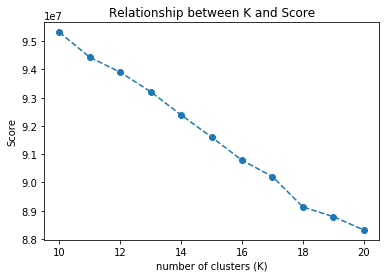

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters,scores,marker='o',linestyle='--')
plt.xlabel('number of clusters (K)')
plt.ylabel('Score')
plt.title("Relationship between K and Score")
plt.show()


In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=18)
model=kmeans.fit(data_pca)
data_pred=model.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population
II used KMeans Algorithm to cluster the PCA-transformed data. From Plots I notice that the score decreases with the number of clusters increase between 18-20 clusters so I decided to choose 18 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [81]:
# Load in the customer demographics data.
 
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [82]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [83]:
customers.isnull().sum().sum()

2252274

In [84]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data

cleand=clean_data(customers,feat_info)

In [85]:
cleand.isnull().sum().sum()

0

In [86]:
cleand.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0,0,0,0,0,0,2.0,0.0,1,3
2,4.0,0.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,0,0,0,0,0,0,2.0,0.0,3,4
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,1.0,1.0,2,4
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4,1
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,0,0,0,0,0,0,2.0,0.0,3,4


In [87]:
missing_below30.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,0,1,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,0,1,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,1,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,0,0,0,1,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,0,1,2.0,1.0,5.0,4.0


In [88]:
set(missing_below30)-set(cleand.columns)

{'GEBAEUDETYP_5.0',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'OST_WEST_KZ_O',
 'OST_WEST_KZ_W',
 'PLZ8_BAUMAX',
 'WOHNLAGE'}

In [89]:
cleand['GEBAEUDETYP_5.0']=0
cleand[ 'LP_LEBENSPHASE_FEIN']=0
cleand['LP_LEBENSPHASE_GROB']=0
cleand['OST_WEST_KZ_O']=0
cleand['PLZ8_BAUMAX']=0
cleand[ 'WOHNLAGE']=0



In [90]:
cleand.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,OST_WEST_KZ_O,PLZ8_BAUMAX,WOHNLAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,2.0,0.0,1,3,0,0,0,0,0,0
2,4.0,0.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,2.0,0.0,3,4,0,0,0,0,0,0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,1.0,1.0,2,4,0,0,0,0,0,0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,4.0,1.0,4,1,0,0,0,0,0,0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,2.0,0.0,3,4,0,0,0,0,0,0


In [92]:


#normalization using StandardScaler
cleand[cleand.columns] = scaler.transform(cleand[cleand.columns].as_matrix())
#transform the customers data using pca object
customers_clean_pca = pca.transform(cleand)




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [93]:
#predict clustering using the kmeans object
predict_customers = KMeans(n_clusters=18).fit_predict(customers_clean_pca)

In [94]:
predict_customers

array([10, 11, 12, ...,  0, 13, 10], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [95]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def compare_plot(general,customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General Clusters')
    sns.countplot(general,ax=ax1)

    ax2.set_title('Customers Clusters')
    sns.countplot(customers,ax=ax2)
    plt.show()

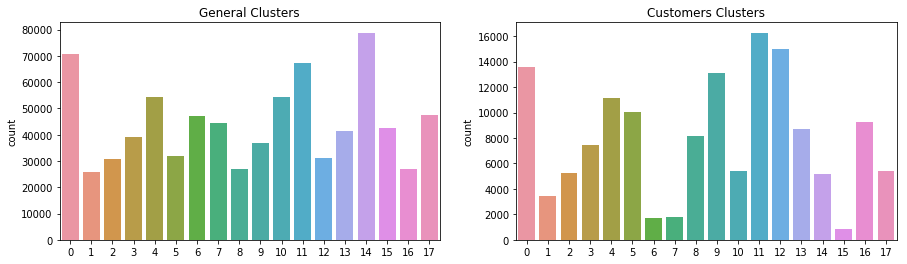

In [96]:
# Plot
compare_plot(data_pred,predict_customers)


In [98]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


Centroid11 = scaler.inverse_transform(pca_80.inverse_transform(model.cluster_centers_[11]))
overrepresented = pd.Series(Centroid11, index = cleand.columns)

In [99]:
overrepresented

ALTERSKATEGORIE_GROB     1.801480
ANREDE_KZ                1.981489
FINANZ_MINIMALIST        1.031176
FINANZ_SPARER            4.539634
FINANZ_VORSORGER         2.139078
FINANZ_ANLEGER           4.414398
FINANZ_UNAUFFAELLIGER    3.943628
FINANZ_HAUSBAUER         4.365209
GREEN_AVANTGARDE         0.039342
HEALTH_TYP               2.374726
RETOURTYP_BK_S           2.824881
SEMIO_SOZ                1.433241
SEMIO_FAM                2.534919
SEMIO_REL                3.259933
SEMIO_MAT                3.936643
SEMIO_VERT               5.350462
SEMIO_LUST               4.630188
SEMIO_ERL                2.257110
SEMIO_KULT               3.282427
SEMIO_RAT                4.359665
SEMIO_KRIT               4.041889
SEMIO_DOM                5.897639
SEMIO_KAEM               5.523047
SEMIO_PFLICHT            6.029410
SEMIO_TRADV              6.003289
SOHO_KZ                  6.047698
VERS_TYP                 5.251697
ANZ_PERSONEN             0.003496
ANZ_TITEL                1.557534
HH_EINKOMMEN_S

In [100]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
Centroid15= scaler.inverse_transform(pca_80.inverse_transform(model.cluster_centers_[15]))
underrepresented = pd.Series(Centroid15, index = cleand.columns)



In [101]:
underrepresented.sort_values(ascending=True)

FINANZTYP_6.0            -0.018987
CAMEO_DEU_2015_1C        -0.013367
CAMEO_DEU_2015_8A        -0.012206
CAMEO_DEU_2015_9C        -0.011719
LP_STATUS_FEIN_8.0       -0.008195
CAMEO_DEU_2015_3D        -0.008191
CAMEO_DEU_2015_8C        -0.008163
CAMEO_DEU_2015_7C        -0.007512
CAMEO_DEU_2015_6A        -0.006794
CAMEO_DEU_2015_4D        -0.006684
CAMEO_DEU_2015_1E        -0.005864
CAMEO_DEU_2015_7D        -0.005375
CAMEO_DEU_2015_2A        -0.004080
GREEN_AVANTGARDE         -0.003635
CAMEO_DEU_2015_6B        -0.003497
CAMEO_DEU_2015_7B        -0.003361
CAMEO_DEU_2015_9B        -0.003097
CAMEO_DEU_2015_1B        -0.002546
ZABEOTYP_4.0             -0.001842
W_KEIT_KIND_HH           -0.001655
CAMEO_DEU_2015_5D        -0.001516
LP_FAMILIE_FEIN_9.0      -0.001342
CAMEO_DEU_2015_8D        -0.001310
CAMEO_DEU_2015_7A        -0.001287
CAMEO_DEU_2015_4C        -0.000623
CAMEO_DEU_2015_6C        -0.000553
LP_FAMILIE_FEIN_6.0      -0.000532
CAMEO_DEU_2015_3A        -0.000033
CAMEO_DEUG_2015_2   

In [102]:
#INVISTIGATE TOP domainant CLUSTERS 9 , 12
Centroid12 = scaler.inverse_transform(pca_80.inverse_transform(model.cluster_centers_[12]))
Centroid9 = scaler.inverse_transform(pca_80.inverse_transform(model.cluster_centers_[9]))


In [103]:
Positive=["SEMIO_ERL",
"ANREDE_KZ","SEMIO_VERT","PLZ8_ANTG3","ALTERSKATEGORIE_GROB","FINANZ_VORSORGER","ZABEOTYP_3.0","LP_STATUS_GROB_1.0","HH_EINKOMMEN_SCORE","WEALTH","SEMIO_FAM","SEMIO_SOZ"]

In [105]:

#invistigate domainant Clusters 
centroids=pd.DataFrame({"feature":cleand.columns,"Cluster11":Centroid11,"Cluster9":Centroid9,"Cluster12":Centroid12})



centroids[centroids["feature"].isin(Positive)]



,feature,Cluster11,Cluster9,Cluster12
0,ALTERSKATEGORIE_GROB,1.801480,1.830673,2.990935
1,ANREDE_KZ,1.981489,1.634764,1.414354
4,FINANZ_VORSORGER,2.139078,2.338550,3.662951
11,SEMIO_SOZ,1.433241,8.911553,7.505856
12,SEMIO_FAM,2.534919,2.626398,3.468745
15,SEMIO_VERT,5.350462,5.581311,3.735634
17,SEMIO_ERL,2.257110,3.659835,4.819466
29,HH_EINKOMMEN_SCORE,1.057076,2.919327,2.499029
53,PLZ8_ANTG3,1.609751,1.719514,2.572201
110,LP_STATUS_GROB_1.0,0.003049,-0.013165,0.003329


### Discussion 3.3: Compare Customer Data to Demographics Data


I notice that  cluster 15, 10 and 8 are significantly higher in the customer data relative to the demographic/population data. These clusters  are male and have a high level of net income and financilally Prepared.

Below tabels descripe  of custumers type in each cluster

#### Cluster 11:

|Top features|Value|Description|
|-------|------------|----------------------------|
|SEMIO_FAM|2.53491|               very high affinity family-minded        |
|SEMIO_VERT|5.350462|         low affinity dreamful         |
|SEMIO_ERL|2.257110|            very high affinity event-oriented   |
|ALTERSKATEGORIE_GROB|1.801480 |       AGE < 30 years old           |
|HH_EINKOMMEN_SCORE|1.057076 |   highest income                       |
|ANREDE_KZ|1.98148 |    male             |
|SEMIO_SOZ 	|1.433241 |   highest affinity  socially-minded            |
|FINANZ_VORSORGER |	2.139078| High Financialy prepared|





#### Cluster 10:
|Top features|Value|Description|
|-------|------------|----------------------------|
|ALTERSKATEGORIE_GROB|1.830673 |  AGE < 30 years old                       |
|HH_EINKOMMEN_SCORE|2.919327 |    very high income |        
|ANREDE_KZ|1.634764 |  male               |
|SEMIO_SOZ|8.911553 |  socially-minded               |
|SEMIO_VERT|5.581311 |       low affinity dreamful           |
|FINANZ_VORSORGER|2.338550|High Financialy prepared|

### Cluster 8:

|Top features|Value|Description|
|-------|------------|----------------------------|
|ALTERSKATEGORIE_GROB|2.990935|     AGE  30 - 45 years old                  |
|HH_EINKOMMEN_SCORE|2.499029|       very high income                 |
|SEMIO_SOZ|7.505856|  lowest affinity socially-minded                        |
|SEMIO_ERL|4.819466|        average affinity   event-oriented      |        
|ANREDE_KZ|1.414354|    male             |        
|FINANZ_VORSORGER|3.662951|    Average Financialy prepared    |


company can use this result to develop and analyze the business.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.